## Plots for Barcharts

#### Content
[GCsnap1 Timings](#GCsnap1)  
[Dask Distributed vs MPI](#dask_distibuted_mpi)   
[Concurrent or sequential](#dependent)  
[GCsnap2 Cluster Refinement](#gc2c)  
[Scalability of GCsnap2 Cluster](#scaling)


##### Packages and main formatting parameters

In [ ]:
# executed in conda evnironment 'plotting' ./conda_envs/plotting

# packages and overall options
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import glob

sns.set(style="white", font='serif', font_scale=1.5)
# fontsize for annotation
font_size = 14
fig_width = 9
fig_height = 4.5
# Set Seaborn style without grid
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True   
# out path
out_folder = ''
legend_anchor=1.2

# colors
# custom_palette = sns.color_palette("colorblind")
# we use the IBM color design which looks ok for all:https://forum.shotcut.org/t/palette-for-colour-blindness/32219
ibm_colors_hex = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
custom_palette = sns.color_palette(ibm_colors_hex)

# annotateion color on columns
annotate_color='black'

# output path for svg plots
path_svg = '/.../plots'

##### Helper functions

In [2]:
def format_with_decimals(value, tick_number):
    return f'{value:.1f}'

# general methods
def format_thousands_separator(x, pos):
    # x are the labels (str), if convertable to float its fine.
    try:
        return '{:,.0f}'.format(int(round(float(x),0))).replace(',', "'")
    except ValueError:
        return x

def formatter(ax, rotation=None):
    # Format the y-axis ticks with a space as a thousand separator
    ax.get_yaxis().set_major_formatter(FuncFormatter(format_thousands_separator))
    
    # Customize tick parameters
    ax.tick_params(axis='both', width=0.8)
    
    # Get the current tick labels
    tick_positions = ax.get_xticks()  # Numeric positions
    tick_labels = [item.get_text() for item in ax.get_xticklabels()]  # Original labels as strings
    
    # Preserve original labels and apply formatting
    formatted_labels = [format_thousands_separator(label, None) for label in tick_labels]
    
    ax.set_xticks(tick_positions)  # Ensure tick positions are preserved
    if rotation is None:
        ax.set_xticklabels(formatted_labels)
    else:
        ax.set_xticklabels(formatted_labels, rotation=rotation, ha="right", rotation_mode="anchor")
        
    # Format legend labels with a space as a thousand separator
    if ax.get_legend() is not None:  # Ensure there is a legend
        for label in ax.get_legend().get_texts():
            label.set_text(format_thousands_separator(label.get_text(), None))    

def make_grid(ax, plt):
    ax.yaxis.grid(True)  # Enable the grid
    plt.setp(ax.get_ygridlines(), 'linestyle', '-')  # Set grid line style
    plt.setp(ax.get_ygridlines(), 'linewidth', 0.5)  # Set grid line width
    plt.setp(ax.get_ygridlines(), 'color', 'gray', 'alpha', 0.5)  # Set grid line color
    
    # Enhance grid visibility beneath the bars
    ax.set_axisbelow(True)    
    
    # Customize the box line width
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

    # Customize tick parameters
    ax.tick_params(axis='both', width=0.5, length=3)

def annotater(ax, plt, annotation_rotated = False):
    
    rot = 0
    if annotation_rotated:
        rot = 90
    
    # find the smallest height
    min_height = float('inf')
    for p in ax.patches:
        if p.get_height() > 0 and p.get_height() < min_height:
            min_height = p.get_height()
            
    # find the largest height
    max_height = float('-inf')
    for p in ax.patches:
        if p.get_height() > 0 and p.get_height() > max_height:
            max_height = p.get_height()            
    
    for p in ax.patches:
        if p.get_width() > 0:
            height = p.get_height()
            digit_count = len(f"{int(height):,}")  # Count digits in the formatted number
            text_position = height + (max_height / min_height / 4)                 
            plt.text(p.get_x() + p.get_width() / 1.8, text_position,
                      format_thousands_separator(p.get_height(), None),
                      ha='center', va='bottom', rotation=rot, color=annotate_color, fontsize=font_size,
                      bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.1)
                      )
            
def finisher(plotname, plt):
    # Remove the top and right spines
    #sns.despine(top=True, right=True)   

    # pack everthing into the plot size
    plt.tight_layout()

    # Save the plot as SVG
    plt.savefig(os.path.join(path_svg,out_folder,plot_name + '.svg'), format='svg', bbox_inches='tight')
    plt.show()

### Timings GCsnap 1.0
<a id="GCsnap1"></a>

Read the GCsnap experimental data and combine them to a dataframe.
Experiments were conducted on miniHPC AMD node.
We did it twice, but the results were equally unstable, meaning experiments did just not finish. So we take the first try.

In [ ]:
# load and read data
path_csv = '/.../experiments/gcsnap1/results'

# all csv files
all_files = glob.glob(os.path.join(path_csv,'**','*.tsv'))

# Read all TSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_threads = int(folder_name.split('_')[2])
    n_rep = int(folder_name.split('_')[4])
    
    # column names
    col_names=['task',
           'total time (s)',
           'count',
           'max time (s)',
           'min time (s)',
           'mean time (s)',
           'std time',
           'median time (s)']
    
    # read the tsv
    df = pd.read_csv(filename, index_col=None, header=1, sep='\t', names=col_names)
    # remove the first row
    df = df.iloc[1:].reset_index(drop=True)
    del df['std time']
    
    # convert to float (as seconds) and int (count)
    df['count'] = df['count'].astype(int)
    df['max time (s)'] = df['max time (s)'].astype(float)
    df['total time (s)'] = df['total time (s)'].astype(float)
    df['min time (s)'] = df['min time (s)'].astype(float)
    df['mean time (s)'] = df['mean time (s)'].astype(float)
    df['median time (s)'] = df['median time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['threads'] = n_threads
    df['repetition'] = n_rep
        
    df_list.append(df)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)

# save for later
df_gcsnap1 = combined_df.copy()
combined_df[(combined_df['task'] == 'All steps 0-10') &(combined_df['targets'] == 100 ) & (combined_df['threads'] == 8)]


,task,total time (s),count,max time (s),min time (s),mean time (s),median time (s),targets,threads,repetition
950,All steps 0-10,280.599065,1,280.599065,280.599065,280.599065,280.599065,100,8,1
984,All steps 0-10,280.220224,1,280.220224,280.220224,280.220224,280.220224,100,8,2
1018,All steps 0-10,253.120161,1,253.120161,253.120161,253.120161,253.120161,100,8,3
1052,All steps 0-10,250.449108,1,250.449108,250.449108,250.449108,250.449108,100,8,4
1086,All steps 0-10,248.012847,1,248.012847,248.012847,248.012847,248.012847,100,8,5


##### Overall runtime for different number of targets and cores

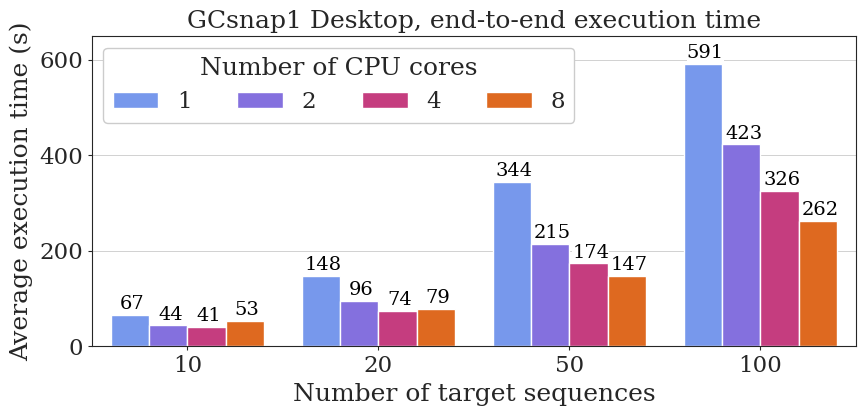

In [4]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'

plot_loop = {
    'gcsnap1_overview' : {
        'on_hue' : 'threads',
        'on_hue_label' : 'Number of CPU cores',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_x' : 'targets',
        'on_x_label' : 'Number of target sequences',
        'columns' : ['targets', 'threads', 'repetition'],
        'filter_cols' : [
            ('task', ['All steps 0-10']),
            ('threads', [1,2,4,8]),
            ('targets', [10,20,50,100])
        ],
        'title' : 'GCsnap1 Desktop, end-to-end execution time',
        'loc' : 'upper left',    
        'ylim' : [0,649]   
    }
}

for k,v in plot_loop.items():
    df = combined_df.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # to annotate bars
    annotate=True
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        y=on_y,
        hue=on_hue,
        estimator=np.mean, 
        errorbar=None,
        # errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=data[on_hue].nunique())
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)


### Dask distributed vs MPI
<a id="dask_distibuted_mpi"></a>
This experiment is to evaluate the usability of Dask distributed vs MPI

##### Read Data

In [ ]:
# path to files depending on the machine
path_csv = '/.../experiments/dask_distributed_assemblies/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', "*.csv"))

# add distributed experiments
path_csv = '/.../experiments/mpi_distributed_assemblies/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', "*.csv")) + all_files

# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=',')
    # rename mpi column
    df.rename(columns={'ranks_per_node': 'cores_per_node'}, inplace=True)
    # ad typte of experiment to df
    df['tool'] = filename.split('/')[-3].split('_')[0]
    df_list.append(df)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
combined_df.head(10)

,n_targets,nodes,cores_per_node,step,repetition,time (s),result_length,tool
0,10000,16,16,get_files,1,0.021103,NaN,mpi
1,10000,16,16,parsed_assemblies,1,8.085497,NaN,mpi
2,10000,16,16,get_files,2,0.020957,NaN,mpi
3,10000,16,16,parsed_assemblies,2,8.226364,NaN,mpi
4,10000,16,16,get_files,3,0.020789,NaN,mpi
5,10000,16,16,parsed_assemblies,3,8.094494,NaN,mpi
6,10000,16,16,get_files,4,0.020879,NaN,mpi
7,10000,16,16,parsed_assemblies,4,8.067551,NaN,mpi
8,10000,16,16,get_files,5,0.021068,NaN,mpi
9,10000,16,16,parsed_assemblies,5,8.226536,NaN,mpi


##### Plots

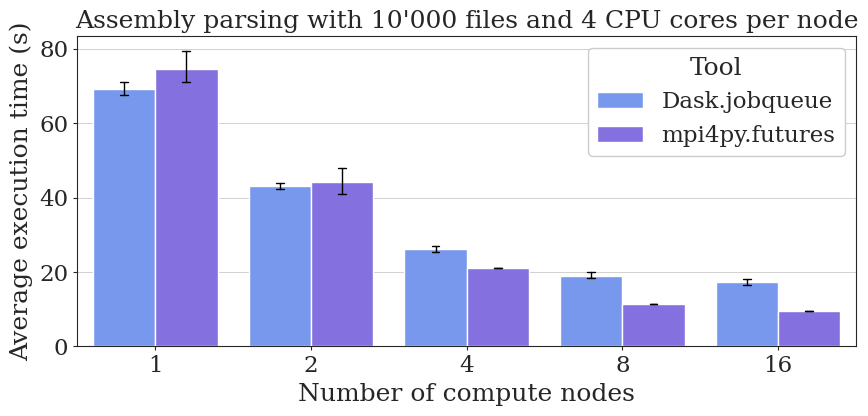

In [6]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'

plot_loop = {
    'dask_mpi_nodes_4' : {
        'on_hue' : 'tool',
        'on_hue_label' : 'Tool',
        'on_y' : 'time (s)',
        'on_y_label' : y_axis_text,
        'on_x' : 'nodes',
        'on_x_label' : 'Number of compute nodes',
        'columns' : ['nodes', 'tool', 'repetition'],
        'filter_cols' : [
            ('tool', ['dask','mpi']),
            ('cores_per_node', [4]),
            ('nodes', [1,2,4,8,16]),
            ('n_targets', [10000])
        ],
        'title' : "Assembly parsing with 10'000 files and 4 CPU cores per node",
        'loc' : 'upper right',
        'ncol' : 1,
        'annotate' : False
    }     
}

for k,v in plot_loop.items():
    df = combined_df.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)
    
    # to annotate bars
    annotate=v.get('annotate', False)
    # ignored if annotate=False
    annotation_rotated=True

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
    
    # Sum time over steps
    data = df.groupby(columns)['time (s)'].sum().reset_index()
    
    # rename methods column
    if 'tool' in data.columns:
        data['tool'] = data['tool'].replace('dask', 'Dask.jobqueue')
        data['tool'] = data['tool'].replace('mpi', 'mpi4py.futures')
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        y=on_y,
        hue=on_hue,
        estimator=np.mean, 
        errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=v.get('ncol'))
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)


### GCsnap2.0 Cluster
<a id="gc2c"></a>

In [ ]:
# path to files for unimproved GCsanp2
path_csv = '/.../experiments/gcsnap2/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**', "timing.csv"))

# add distributed experiments
path_csv = '/.../experiments/gcsnap2_improved_taxonomy/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**',"timing.csv")) + all_files


# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_nodes = int(folder_name.split('_')[2])
    n_processes = int(folder_name.split('_')[4])
    n_cores = int(folder_name.split('_')[6])
    n_rep = int(folder_name.split('_')[8])
    
    # column names
    col_names=['task',
           'total time (s)']
    
    # read the csv
    df = pd.read_csv(filename, index_col=None, header=0, sep=',', names=col_names)
    
    # convert to float (as seconds) and int (count)
    df['total time (s)'] = df['total time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['nodes'] = n_nodes
    df['ranks'] = n_processes
    df['cores'] = n_cores
    df['repetition'] = n_rep


    # add variant of results
    if filename.split('/')[-4] == 'gcsnap2':
        df['variant'] = 'GCsnap2 Cluster (A.)'
    elif filename.split('/')[-4] == 'gcsnap2_improved_taxonomy':
        df['variant'] = 'Improved Taxonomy (B.)'
        
    df_list.append(df)

    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_gc2 = combined_df.copy()

filter_l = ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate','Producing output']

# combine results to blocks
steps = ['All steps 0-10',
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']
df_gc2 = df_gc2[df_gc2['task'].isin(steps)].copy()
df_gc2_steps = df_gc2.copy()
df_gc2['task'] = df_gc2['task'].replace(steps[0], 'End-to-end')
df_gc2['task'] = df_gc2['task'].replace(steps[2], 'Step 1:\nCollect')
df_gc2['task'] = df_gc2['task'].replace(steps[6], 'Step 2:\nFind families')
df_gc2['task'] = df_gc2['task'].replace(steps[7:11], 'Step 3:\nAnnotate')
df_gc2['task'] = df_gc2['task'].replace(steps[11:], 'Producing output')
df_gc2 = df_gc2[df_gc2['task'].isin(filter_l)].copy()
block_df_gc2 = df_gc2.groupby(['task', 'targets', 'nodes', 'ranks', 'cores', 'repetition','variant'])['total time (s)'].sum().reset_index()
bs_df_gc2 = pd.concat([block_df_gc2,df_gc2_steps], axis=0, ignore_index=True).copy()
bs_df_gc2.head(10)

,task,targets,nodes,ranks,cores,repetition,variant,total time (s)
0,End-to-end,1000,4,2,1,1,GCsnap2 Cluster (A.),408.435756
1,End-to-end,1000,4,2,1,1,Improved Taxonomy (B.),171.815974
2,End-to-end,1000,4,2,1,2,GCsnap2 Cluster (A.),405.509059
3,End-to-end,1000,4,2,1,2,Improved Taxonomy (B.),172.417014
4,End-to-end,1000,4,2,1,3,GCsnap2 Cluster (A.),408.214328
5,End-to-end,1000,4,2,1,3,Improved Taxonomy (B.),171.380710
6,End-to-end,1000,4,2,1,4,GCsnap2 Cluster (A.),409.029468
7,End-to-end,1000,4,2,1,4,Improved Taxonomy (B.),172.071478
8,End-to-end,1000,4,2,1,5,GCsnap2 Cluster (A.),409.910320
9,End-to-end,1000,4,2,1,5,Improved Taxonomy (B.),170.088952


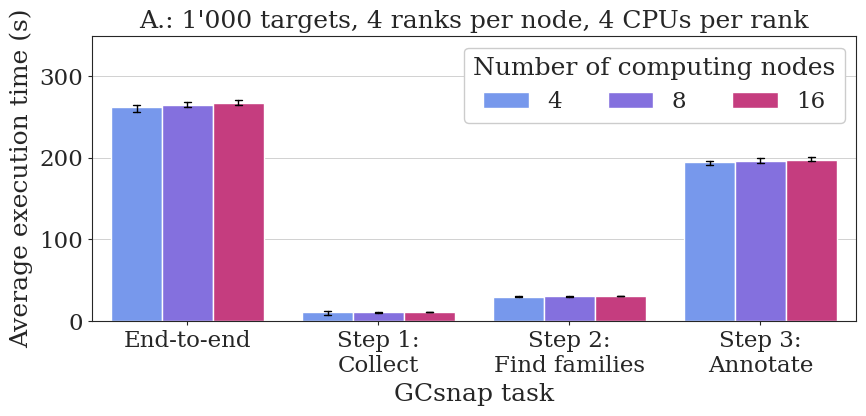

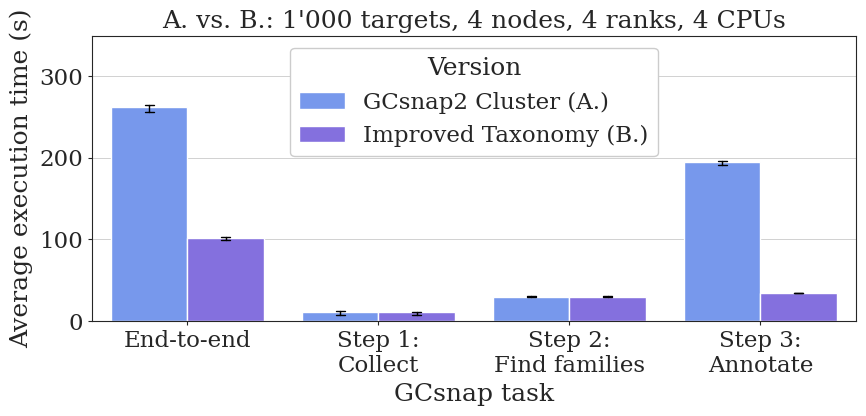

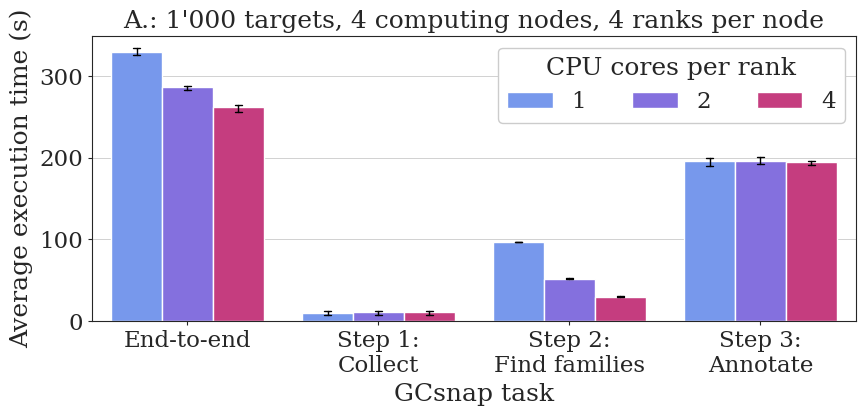

In [7]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'
         
# possible steps:
steps = ['All steps 0-10', 
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']

plot_loop = {
    'gcsnap2_steps' : {
        'on_x' : 'task',
        'on_x_label' : 'GCsnap task',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_hue' : 'nodes',
        'on_hue_label' : 'Number of computing nodes',
        'columns' : ['task', 'nodes', 'repetition'],
        'filter_cols' : [
            ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
            ('variant', ['GCsnap2 Cluster (A.)']),
            ('nodes', [4, 8, 16]),
            ('ranks', [4]),
            ('cores', [4]),
            ('targets', [1000])
        ],
        'x_order' : 'task',
        'hue_order' : 'nodes',
        'title' : "A.: 1'000 targets, 4 ranks per node, 4 CPUs per rank",
        'loc' : 'upper right',
        'ncol' : 3,
        'annotate' : False,
        'steps_of_interest' : False,
        'ylim': [0,349]
    },    
    'gcsnap2_improvement' : {
            'on_x' : 'task',
            'on_x_label' : 'GCsnap task',
            'on_y' : 'total time (s)',
            'on_y_label' : y_axis_text,
            'on_hue' : 'variant',
            'on_hue_label' : 'Version',
            'columns' : ['task', 'variant', 'repetition'],
            'filter_cols' : [
                ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
                ('variant', ['GCsnap2 Cluster (A.)','Improved Taxonomy (B.)']),                
                ('nodes', [4]),
                ('ranks', [4]),
                ('cores', [4]),
                ('targets', [1000])
            ],
            'x_order' : 'task',
            'hue_order' : 'variant',
            'title' : "A. vs. B.: 1'000 targets, 4 nodes, 4 ranks, 4 CPUs",
            'loc' : 'upper center',
            'ncol' : 1,
            'annotate' : False,
            'steps_of_interest' : False,
            'ylim': [0,349]
        },    
    'gcsnap2_cpu' : {
            'on_x' : 'task',
            'on_x_label' : 'GCsnap task',
            'on_y' : 'total time (s)',
            'on_y_label' : y_axis_text,
            'on_hue' : 'cores',
            'on_hue_label' : 'CPU cores per rank',
            'columns' : ['task', 'cores', 'repetition'],
            'filter_cols' : [
                ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
                ('variant', ['GCsnap2 Cluster (A.)']),                
                ('nodes', [4]),
                ('ranks', [4]),
                ('cores', [1,2,4]),
                ('targets', [1000])
            ],
            'x_order' : 'task',
            'hue_order' : 'cores',
            'title' : "A.: 1'000 targets, 4 computing nodes, 4 ranks per node",
            'loc' : 'upper right',
            'ncol' : 3,
            'annotate' : False,
            'steps_of_interest' : False,
            'ylim': [0,349]
        },           
}

for k,v in plot_loop.items():
    df = bs_df_gc2.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

        # to annotate bars
    annotate=v.get('annotate', False)
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
            
    # search order as defined in plot loop
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    x_order = tuple_[1]
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    hue_order = tuple_[1]
    
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order, 
        estimator=np.mean, 
        errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)
    
    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=v.get('ncol'))
    leg.get_frame().set_alpha(1) 
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)

### Scaling of GCsnap

In [ ]:
# path to files for unimproved GCsanp2
path_csv = '/.../experiments/gcsnap2_amd/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**', "timing.csv"))

# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_nodes = int(folder_name.split('_')[2])
    n_processes = int(folder_name.split('_')[4])
    n_cores = int(folder_name.split('_')[6])
    n_rep = int(folder_name.split('_')[8])
    
    # column names
    col_names=['task',
           'total time (s)']
    
    # read the csv
    df = pd.read_csv(filename, index_col=None, header=0, sep=',', names=col_names)
    
    # convert to float (as seconds) and int (count)
    df['total time (s)'] = df['total time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['nodes'] = n_nodes
    df['ranks'] = n_processes
    df['cores'] = n_cores
    df['repetition'] = n_rep
    df['total_ranks'] = str(n_processes) + '×' + str(n_cores)
        
    df_list.append(df)
    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_gc2 = combined_df.copy()

filter_l = ['End-to-end','Parse Assemblies','Find Families','Annotate Functions','Find Operons','Other Substeps']

# combine results to blocks
steps = ['All steps 0-10',
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']
df_gc2 = df_gc2[df_gc2['task'].isin(steps)].copy()
df_gc2_steps = df_gc2.copy()
df_gc2['task'] = df_gc2['task'].replace(steps[0], 'End-to-end')
df_gc2['task'] = df_gc2['task'].replace(steps[4], 'Parse Assemblies')
df_gc2['task'] = df_gc2['task'].replace(steps[6], 'Find Families')
df_gc2['task'] = df_gc2['task'].replace(steps[7], 'Annotate Functions')
df_gc2['task'] = df_gc2['task'].replace(steps[8], 'Find Operons')
df_gc2['task'] = df_gc2['task'].replace(steps[1], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[3], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[5], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[9:12], 'Other Substeps')
df_gc2 = df_gc2[df_gc2['task'].isin(filter_l)].copy()
block_df_gc2 = df_gc2.groupby(['task', 'targets', 'nodes', 'total_ranks' , 'ranks', 'cores', 'repetition'])['total time (s)'].sum().reset_index()
bs_df_gc2 = pd.concat([block_df_gc2,df_gc2_steps], axis=0, ignore_index=True).copy()
bs_df_gc2.head(10)

,task,targets,nodes,total_ranks,ranks,cores,repetition,total time (s)
0,Annotate Functions,10000,1,12x10,12,10,1,145.045865
1,Annotate Functions,10000,1,12x10,12,10,2,142.730980
2,Annotate Functions,10000,1,12x10,12,10,3,157.877519
3,Annotate Functions,10000,1,12x10,12,10,4,143.617739
4,Annotate Functions,10000,1,12x10,12,10,5,140.762850
5,Annotate Functions,10000,1,16x8,16,8,1,142.889993
6,Annotate Functions,10000,1,16x8,16,8,2,143.463529
7,Annotate Functions,10000,1,16x8,16,8,3,141.773695
8,Annotate Functions,10000,1,16x8,16,8,4,141.533309
9,Annotate Functions,10000,1,16x8,16,8,5,140.508674


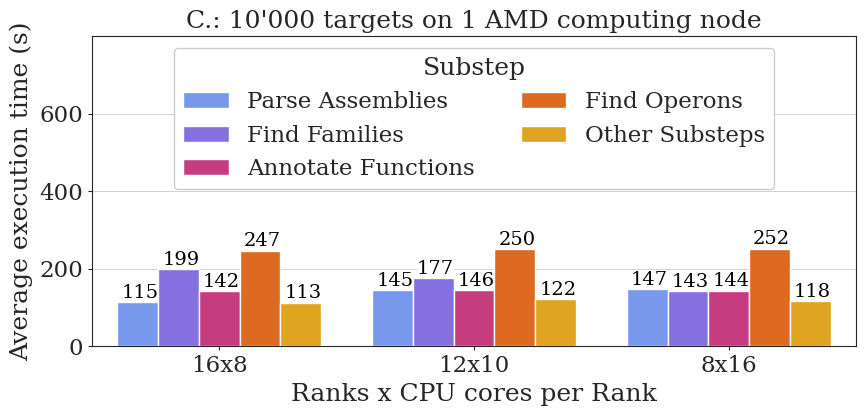

In [ ]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'
         
# possible steps:
steps = ['All steps 0-10', 
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']

plot_loop = {
    'gcsnap2_scaling' : {
        'on_x' : 'total_ranks',
        'on_x_label' : 'MPI ranks × CPU cores per Rank',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_hue' : 'task',
        'on_hue_label' : 'Substep',
        'columns' : ['task', 'total_ranks', 'repetition'],
        'filter_cols' : [
            ('task', ['Parse Assemblies','Find Families','Annotate Functions','Find Operons','Other Substeps']),
            ('total_ranks', ['16×8','12×10','8×16']),
            ('targets', [10000])
        ],
        'x_order' : 'total_ranks',
        'hue_order' : 'task',
        'title' : "C.: 10'000 targets on 1 AMD computing node",
        'loc' : 'upper center',
        'ncol' : 2,
        'annotate' : True,
        'steps_of_interest' : False,
        'ylim': [0,799]
    }
}

for k,v in plot_loop.items():
    df = bs_df_gc2.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

        # to annotate bars
    annotate=v.get('annotate', False)

    if not annotate:
        errorbar = lambda x: (x.min(), x.max())
    else:
        errorbar = None
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
            
    # search order as defined in plot loop
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    x_order = tuple_[1]
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    hue_order = tuple_[1]
    
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order, 
        estimator=np.mean, 
        errorbar = errorbar, 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)
    
    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=v.get('ncol'))
    leg.get_frame().set_alpha(1) 
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)